# Projekt ML - Michał Kowalik

# Część I

In [1]:
# Baseline dla zbioru CIFAR-10 - regresja logistyczna w wersji multiclass
# Przy submitowaniu predykcji proszę używać funkcji save_labels

import os

os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = "device=cuda0"  

import keras
import pickle

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

import tqdm
from keras.models import Sequential
from keras.layers.noise import GaussianNoise
from keras.layers import Dense, Activation, Dropout, Flatten, Input, UpSampling2D
from keras.optimizers import SGD
from keras.models import Model

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.constraints import maxnorm

import matplotlib.pyplot as plt
from __future__ import print_function

Using Theano backend.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda2\lib\site-packages\theano\gpuarray\__init__.py", line 179, in <module>
    use(config.device)
  File "C:\ProgramData\Anaconda2\lib\site-packages\theano\gpuarray\__init__.py", line 166, in use
    init_dev(device, preallocate=preallocate)
  File "C:\ProgramData\Anaconda2\lib\site-packages\theano\gpuarray\__init__.py", line 65, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu\gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9415)
  File "pygpu\gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9106)
  File "pygpu\gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13468)
GpuArrayException: Error loading library: 0


Ładujemy dane, przy okazji przekształcając je do postaci lubianej przez keras.

In [2]:
def save_labels(arr, filename):
    pd_array = pd.DataFrame(arr)
    pd_array.index.names = ["Id"]
    pd_array.columns = ["Prediction"]
    pd_array.to_csv(filename)

def load_labels(filename):
    return pd.read_csv(filename, index_col=0).values.ravel()

X_train = np.load("X_train.npy")
y_train = load_labels("y_train.csv")
X_test = np.load("X_test.npy")

X_train_small = np.load("X_train_small.npy")
y_train_small = load_labels("y_train_small.csv")

y_train_one_hot = keras.utils.to_categorical(y_train)
y_train_small_one_hot = keras.utils.to_categorical(y_train_small)


Przekształcamy na float i skalujemy

In [3]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_small = X_train_small.astype('float32') / 255.0

print (X_train.shape)
print (X_test.shape)
print (X_train_small.shape)

(50000L, 3072L)
(10000L, 3072L)
(5000L, 3072L)


In [4]:
print (y_train_small.max())
print (y_train_small.min())
classes_number = y_train_small.max() - y_train_small.min() + 1
print (classes_number)

9
0
10


Następnie dzielimy na dane trenujące i testujące. Moglibyśmy użyć cross-entropy, ale bardzo by to wydłużyło cały proces doboru parametrów. Chcemy tylko mniej-więcej wybrać parametry, a następnie i tak je będziemy testować na całym zbiorze trenującym już przy użyciu cross-entropy.

In [5]:
X_tr_s, X_te_s, y_tr_s, y_te_s = train_test_split(X_train_small, y_train_small_one_hot, test_size=0.25)
X_tr, y_tr = X_train, y_train

Spróbujemy wybrać najlepsze parametry dla sieci neuronowej. Jest to:

<b>learning rate</b> - parametr stanowiący o szybkości uczenia się sieci - współczynnik przy gradiencie wag w algorytmie Gradient Descent. Gdy jest zbyt mały - sieć uczy się bardzo wolno, zbyt duży - przeskakuje przez minimum, przez co oddala się od optymalnego rozwiązania. <br>
<b>activation_first</b> - funkcja aktywacji pierwszej warstwy <br>
<b>actication_second</b>- funkcja aktywacji drugiej warstwy <br>
<b>hidden_size</b> - liczba neuronów w warstwie ukrytej <br>
Najważniejsze z nich, to <b>hidden_size</b> i <b>learning_rate</b>

In [48]:
# Najpierw zobaczymy jak sobie radzi na prostej sieci 3-warstwowej na malych danych

for lr in [0.01, 0.05, 0.1, 0.2]:
    for activation_first in ['relu', 'softmax']:
        for activation_second in ['softmax', 'sigmoid']:
            for hidden_size in [10, 50, 100, 250, 500, 1000]:

                batch = 1000

                model = Sequential()
                model.add(Dense(hidden_size, input_shape=(X_train_small.shape[1],)))
                model.add(Activation(activation_first))
                model.add(Dense(classes_number, input_shape=(hidden_size, )))
                model.add(Activation(activation_second))

                model.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

                print "Testing lr:", lr, "activations:", activation_first, ",", activation_second, \
                    "hidden layer size:", hidden_size

                model.fit(X_tr_s, y_tr_s, epochs=50, batch_size=batch, verbose=0)

                y_pred = model.predict(X_te_s, batch_size=batch)

                print "Score: ", accuracy_score(y_te_s.argmax(axis=1), y_pred.argmax(axis=1))

    

Testing lr: 0.01 activations: relu , softmax hidden layer size: 10
Score:  0.2928
Testing lr: 0.01 activations: relu , softmax hidden layer size: 50
Score:  0.3472
Testing lr: 0.01 activations: relu , softmax hidden layer size: 100
Score:  0.38
Testing lr: 0.01 activations: relu , softmax hidden layer size: 250
Score:  0.3848
Testing lr: 0.01 activations: relu , softmax hidden layer size: 500
Score:  0.3848
Testing lr: 0.01 activations: relu , softmax hidden layer size: 1000
Score:  0.3992
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 10


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock
INFO:theano.gof.compilelock:Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock


Score:  0.2592
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 50
Score:  0.3216
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 100
Score:  0.32
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 250
Score:  0.348
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 500
Score:  0.3496
Testing lr: 0.01 activations: relu , sigmoid hidden layer size: 1000
Score:  0.3952
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 10
Score:  0.216
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 50
Score:  0.16
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 100
Score:  0.1552
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 250
Score:  0.0896
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 500
Score:  0.0944
Testing lr: 0.01 activations: softmax , softmax hidden layer size: 1000
Score:  0.0952
Testing lr: 0.01 activations: softmax , sigmoid hidden layer 

Widzimy, ze siec osiaga najlepsze wyniki dla lr=0.05, funkcji aktywacji relu, sigmoid i wiekosci warsty ukrytej na poziomie 500-1000. Zatem sprobujmy przeprowadzić cross-validację sieci na dla calych danych Train.

In [173]:
lr = 0.05
activation_first = 'relu'
activation_second = 'sigmoid'
hidden_sizes = [500, 1000, 1500, 2000]

for hidden_size in hidden_sizes:
    
    n_folds = 3
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    print "Testing lr:", lr, "activations:", activation_first, ",", activation_second, \
        "hidden layer size:", hidden_size
        
    scores = []

    for i, (train, test) in enumerate(skf.split(X_tr, y_train)):
        print "Running Fold", i+1, "/", n_folds

        batch = 1000

        model = Sequential()
        model.add(Dense(hidden_size, input_shape=(X_tr.shape[1],)))
        model.add(Activation(activation_first))
        model.add(Dense(classes_number, input_shape=(hidden_size, )))
        model.add(Activation(activation_second))

        model.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
        model.fit(X_tr[train], y_train_one_hot[train], epochs=50, batch_size=batch, verbose=0)
        
        y_pred = model.predict(X_tr[test], batch_size=batch)
        
        score = accuracy_score(y_train_one_hot[test].argmax(axis=1), y_pred.argmax(axis=1))
        print "Score: ", score
        scores.append(score)

    print "Score mean: ", np.mean(scores)
    print 



Testing lr: 0.05 activations: relu , sigmoid hidden layer size: 500
Running Fold 1 / 3
Score:  0.50575884823
Running Fold 2 / 3
Score:  0.456328734253
Running Fold 3 / 3
Score:  0.467647058824
Score mean:  0.476578213769

Testing lr: 0.05 activations: relu , sigmoid hidden layer size: 1000
Running Fold 1 / 3
Score:  0.472765446911
Running Fold 2 / 3
Score:  0.453929214157
Running Fold 3 / 3
Score:  0.476770708283
Score mean:  0.467821789784

Testing lr: 0.05 activations: relu , sigmoid hidden layer size: 1500
Running Fold 1 / 3


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock
INFO:theano.gof.compilelock:Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock


Score:  0.511937612478
Running Fold 2 / 3
Score:  0.495440911818
Running Fold 3 / 3
Score:  0.502040816327
Score mean:  0.503139780207

Testing lr: 0.05 activations: relu , sigmoid hidden layer size: 2000
Running Fold 1 / 3


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock
INFO:theano.gof.compilelock:Refreshing lock C:\Users\Kowalik\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.13-64\lock_dir\lock


Score:  0.490161967606
Running Fold 2 / 3
Score:  0.478764247151
Running Fold 3 / 3
Score:  0.506842737095
Score mean:  0.491922983951



Widzimy zatem, że na prostej sieci neuronowej z jedną warstwą ukrytą, na cross-entropy estymator z 3-ma foldami na zbiorze Train osiąga wynik na poziomie 50% accuracy, przy learning rate 0.05, funkcji aktywacji pierwszej warstwy: relu i funkcji aktywacji drugiej warstwy: sigmoid i rozmiarze ukrytej warstwy na poziomie 1500.

Moglibyśmy jeszcze dobrać optymalną liczbę epok uczenia, jednak zapewne wynik uda nam się podbić nieznacznie, zatem spróbujemy użyć innej metody, jaką jest <b>prosta sieć konwolucyjna</b>.

Przygotujmy dane. Spakujmy w odpowiedni sposób wartości poszczególnych kolorów dla danych pikseli

In [9]:
def pack_color_image(tab):
    tab_red = tab[:,:1024]
    tab_green = tab[:,1024:2048]
    tab_blue = tab[:,2048:3072]

    ret = np.dstack((tab_red, tab_green, tab_blue))

    return ret

In [27]:
X_tr_s_reshaped = pack_color_image(X_tr_s).reshape(-1, 32, 32, 3)
X_te_s_reshaped = pack_color_image(X_te_s).reshape(-1, 32, 32, 3)
X_train_small_reshaped = pack_color_image(X_train_small).reshape(-1, 32, 32, 3)
print (X_tr_s_reshaped.shape)
print (X_te_s_reshaped.shape)

print (y_tr_s.shape)
print (y_te_s.shape)

num_classes = y_te_s.shape[1]
print (num_classes)

X_tr_reshaped = pack_color_image(X_tr).reshape(-1, 32, 32, 3)
print (X_tr_reshaped.shape)

X_test_reshaped = pack_color_image(X_test).reshape(-1, 32, 32, 3)

(3750L, 32L, 32L, 3L)
(1250L, 32L, 32L, 3L)
(3750L, 10L)
(1250L, 10L)
10
(50000L, 32L, 32L, 3L)


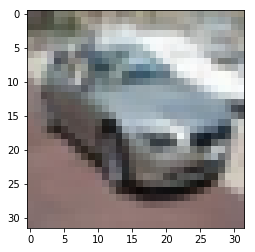

In [13]:
from matplotlib import pyplot as plt

img = X_tr_s_reshaped[2]

plt.imshow(img)
plt.show()

Na podzielonych danych na trenujące i testujące próbujemy dobrać najlepsze parametry dla tej sieci. Z powodu długich obliczeń, robimy to na danych ze zebioru small, a później zrobimy cross-validację modelu na pełnych danych. Testowane parametry:

<b>dense_size</b> - rozmiar warstwy ukrytej pomiędzy częścią konwolucyjną a sekwencyjną<br>
<b>dropout</b> - wartość parametru dropout dla dwóch warstw Dropout w modelu sieci<br>
<b>lrate</b> - learning rate dla algorytmu SGD<br>
<b>kernel_size</b> - rozmiar kernali dla warstw konwolucyjnych sieci<br>

In [ ]:
# models = []
scores = []
fit_histories = []

for dense_size in [512, 1000]:
    for dropout in [0.2, 0.5]:
        for lrate in [0.1, 0.01, 0.001]:
            for kernel_size in [(3,3), (5,5), (8,8)]:

                print "Training network on: "
                print "kernel size:", kernel_size
                print "lrate:      ", lrate
                print "dropout:    ", dropout
                print "dense size: ", dense_size

                model = Sequential()

                model.add(Conv2D(32, kernel_size, input_shape=(32, 32, 3), padding='same', activation='relu'))
                model.add(Dropout(dropout))
                model.add(Conv2D(32, kernel_size, activation='relu', padding='same'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Flatten())
                model.add(Dense(dense_size, activation='relu', kernel_constraint=maxnorm(3)))
                model.add(Dropout(dropout))
                model.add(Dense(num_classes, activation='softmax'))

                # Compile model
                epochs = 25
                decay = lrate/epochs
                momentum = 0.9
                sgd = SGD(lr=lrate, momentum=momentum, decay=decay)
                model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

                fit_history = model.fit(X_tr_s_reshaped, y_tr_s, validation_data=(X_te_s_reshaped, y_te_s), epochs=epochs, batch_size=32, verbose=2)
                score = model.evaluate(X_te_s_reshaped, y_te_s, verbose=0)[1]*100

#                 models.append(model)
                scores.append(score)
                fit_histories.append(fit_history)
                print("Accuracy: %.2f%%" % score)
                print
                
                

Wyniki policzone na komputerze z GPU odostępnionym dzięki uprzejmości kolegi, Michała Goldy. Podsumowanie poniżej. Pełny log w załączonym pliku 'out.out'.

<pre>(50000, 3072)
(10000, 3072)
(5000, 3072)
9
0
10
(3750, 32, 32, 3)
(1250, 32, 32, 3)
(3750, 10)
(1250, 10)
10
Training network on: 
kernel size: (3, 3)
lrate:       0.0001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 42.08%

Training network on: 
kernel size: (5, 5)
lrate:       0.0001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 44.40%

Training network on: 
kernel size: (8, 8)
lrate:       0.0001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 42.96%

Training network on: 
kernel size: (3, 3)
lrate:       0.001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 44.08%

Training network on: 
kernel size: (5, 5)
lrate:       0.001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 43.92%

Training network on: 
kernel size: (8, 8)
lrate:       0.001
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 40.48%

Training network on: 
kernel size: (3, 3)
lrate:       0.01
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 27.04%

Training network on: 
kernel size: (5, 5)
lrate:       0.01
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.60%

Training network on: 
kernel size: (8, 8)
lrate:       0.01
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 23.12%

Training network on: 
kernel size: (3, 3)
lrate:       0.1
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.36%

Training network on: 
kernel size: (5, 5)
lrate:       0.1
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.60%

Training network on: 
kernel size: (8, 8)
lrate:       0.1
dropout:     0.2
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.68%

Training network on: 
kernel size: (3, 3)
lrate:       0.0001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 41.68%

Training network on: 
kernel size: (5, 5)
lrate:       0.0001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 43.68%

Training network on: 
kernel size: (8, 8)
lrate:       0.0001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 44.40%

Training network on: 
kernel size: (3, 3)
lrate:       0.001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 39.92%

Training network on: 
kernel size: (5, 5)
lrate:       0.001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 38.24%

Training network on: 
kernel size: (8, 8)
lrate:       0.001
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 31.60%

Training network on: 
kernel size: (3, 3)
lrate:       0.01
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.44%

Training network on: 
kernel size: (5, 5)
lrate:       0.01
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.76%

Training network on: 
kernel size: (8, 8)
lrate:       0.01
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.68%

Training network on: 
kernel size: (3, 3)
lrate:       0.1
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.68%

Training network on: 
kernel size: (5, 5)
lrate:       0.1
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 10.08%

Training network on: 
kernel size: (8, 8)
lrate:       0.1
dropout:     0.5
dense size:  512
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.68%

Training network on: 
kernel size: (3, 3)
lrate:       0.0001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 41.20%

Training network on: 
kernel size: (5, 5)
lrate:       0.0001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 44.48%

Training network on: 
kernel size: (8, 8)
lrate:       0.0001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 45.52%

Training network on: 
kernel size: (3, 3)
lrate:       0.001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 47.68%

Training network on: 
kernel size: (5, 5)
lrate:       0.001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 44.72%

Training network on: 
kernel size: (8, 8)
lrate:       0.001
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 38.72%

Training network on: 
kernel size: (3, 3)
lrate:       0.01
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.60%

Training network on: 
kernel size: (5, 5)
lrate:       0.01
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.44%

Training network on: 
kernel size: (8, 8)
lrate:       0.01
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 21.84%

Training network on: 
kernel size: (3, 3)
lrate:       0.1
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 10.08%

Training network on: 
kernel size: (5, 5)
lrate:       0.1
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.76%

Training network on: 
kernel size: (8, 8)
lrate:       0.1
dropout:     0.2
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.76%

Training network on: 
kernel size: (3, 3)
lrate:       0.0001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 42.24%

Training network on: 
kernel size: (5, 5)
lrate:       0.0001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 45.36%

Training network on: 
kernel size: (8, 8)
lrate:       0.0001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 43.52%

Training network on: 
kernel size: (3, 3)
lrate:       0.001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 45.36%

Training network on: 
kernel size: (5, 5)
lrate:       0.001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 38.64%

Training network on: 
kernel size: (8, 8)
lrate:       0.001
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 33.92%

Training network on: 
kernel size: (3, 3)
lrate:       0.01
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 9.60%

Training network on: 
kernel size: (5, 5)
lrate:       0.01
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 12.56%

Training network on: 
kernel size: (8, 8)
lrate:       0.01
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 10.56%

Training network on: 
kernel size: (3, 3)
lrate:       0.1
dropout:     0.5
dense size:  1024
Train on 3750 samples, validate on 1250 samples
Accuracy: 10.24%
</pre>

Widzimy, że na danych testowych najlepsze wyniki uzyskiwane są dla parametrów: 

dense_size = 1024, kernel_size=(3,3), dropout=0.2, lrate 0.0001 i 0.001.

Zatem przeprowadzimy cross-validację modelu na danych (X_train, y_train) i tych parametrów. <br>
Największe znaczenie miało tutaj lrate, które zbyt duże nie pozwalało uczyć modelu (wyniki wyraźnie odbiegały)

In [ ]:
dense_size = 1024
dropout = 0.2
kernel_size = (3,3)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

for lrate in [0.0005, 0.001]:
    
    n_folds = 2
    skf = StratifiedKFold(n_splits=2, shuffle=True)

    print ("Training network on: ")
    print ("kernel size:", kernel_size)
    print ("lrate:      ", lrate)
    print ("dropout:    ", dropout)
    print ("dense size: ", dense_size)
        
    scores = []

    for i, (train, test) in enumerate(skf.split(X_tr, y_train)):
        print
        print ("Running Fold", i+1, "/", n_folds)

        model = Sequential()

        model.add(Conv2D(32, kernel_size, input_shape=(32, 32, 3), padding='same', activation='relu'))
        model.add(Dropout(dropout))
        model.add(Conv2D(32, kernel_size, activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(dense_size, activation='relu', kernel_constraint=maxnorm(3)))
        model.add(Dropout(dropout))
        model.add(Dense(num_classes, activation='softmax'))

        # Compile model
        epochs = 75
        decay = lrate/epochs
        momentum = 0.9
        sgd = SGD(lr=lrate, momentum=momentum, decay=decay)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        fit_history = model.fit(X_tr_reshaped[train], y_train_one_hot[train], validation_data=(X_tr_reshaped[test], y_train_one_hot[test]), epochs=epochs, batch_size=32, verbose=2)

        y_pred = model.predict(X_tr_reshaped[test], batch_size=32)
        score = accuracy_score(y_train_one_hot[test].argmax(axis=1), y_pred.argmax(axis=1))

        print ("Score: ", score)
        scores.append(score)
    
#         plt.plot(fit_history.history['acc'])
        print
        print ('acc:     ', ["{0:0.3f}".format(i) for i in fit_history.history['acc']])
        print 

#         plt.plot(fit_history.history['val_acc'])
        print ('val_acc: ', ["{0:0.3f}".format(i) for i in fit_history.history['val_acc']])
        filename = 'acc_' + str(lrate) + '_' + str(i) + '.png'
#         plt.savefig(filename)
#         plt.close()

    print ("---> Score mean: ", np.mean(scores))
    print 



Wyniki policzone na komputerze z GPU odostępnionym dzięki uprzejmości kolegi, Michała Goldy. Podsumowanie poniżej.

<pre>Dla danego lrate model osiąga wynik na poniższym poziomie po 75 epokach uczenia <br>
lrate=0.0001 -> 57.8%
lrate=0.0005 -> 64.1%
lrate=0.001 -> 64.2% </pre>
<i>Dokładne logi z przebiegów cross-validacji w plikach: 'out_0.0001.out', 'out_0.0005.out', 'out_0.001.out'</i>

Zatem wytrenujmy model na całych danych dla <b>lrate=0.001</b> i zapiszmy wynik dla X_test, następnie wyślemy go na kaggle:

In [ ]:
X_test_reshaped = pack_color_image(X_test).reshape(-1, 32, 32, 3)

dense_size = 1024
dropout = 0.2
kernel_size = (3,3)
lrate = 0.001

model = Sequential()

model.add(Conv2D(32, kernel_size, input_shape=(32, 32, 3), padding='same', activation='relu'))
model.add(Dropout(dropout))
model.add(Conv2D(32, kernel_size, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(dense_size, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 100
decay = lrate/epochs
momentum = 0.9
sgd = SGD(lr=lrate, momentum=momentum, decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

fit_history = model.fit(X_tr_reshaped, y_train_one_hot, epochs=epochs, batch_size=32, verbose=2)

y_pred = model.predict(X_test_reshaped, batch_size=32)
y_pred = y_pred.argmax(axis=1)

save_labels(y_pred, 'y_pred_kowalik.csv')

print ("DONE!")

<i>Log z przebiegu trenowania i predykcji w pliku: 'out_test_set.out'</i> 

Wynik: <br>
<img src="./figures_mk/result_supervised.png"> <br>
<img src="./figures_mk/biceps.png"> <br>

# Część II

Część druga polega na zaimplementowaniu autoenkodera. Wykorzystamy autoenkoder konwolucyjny na bazie powyższego modelu.

Autoenkoderem jest sieć neuronowa stworzona z identycznych warstw jak powyżej, oraz dołożonych wartst o odwrotnym działaniu w odwrotnej kolejności. Taka sieć jest trenowana na danych (X_train, <b>X_train</b>), przez co uczy się dobrej reprezentacji danych, dla któych następuje kodowanie i dekodowanie. Jest to uczenie nienadzorowane, gdyż nie występują przy uczeniu etykiety danych, a autoenkoder stara się nauczyć takiej reprezentacji, które będą odzwierciedlały dane wejściowe. Następnie do części kodującej jest dokładana 'płaska' część sieci, identyczna jak w zadaniu powyżej, na której <b>dotrenowywany</b> jest wytrenowany już częściowo enkoder razem z płaską częścią sieci, dzięki czemu sieć pomimo nauczenia reprezentacji, jest w stanie nauczyć się odpowiednich etykiet.

Założymy, że parametry są już dobrane przez model evaluation zasosowany powyżej, także parametrów dla sieci użyjemy tych, które okazały się najlepsze w pierwszej części.

In [6]:
from keras.layers import Input, Embedding

In [23]:
dense_size = 1024
dropout = 0.2
kernel_size = (3,3)
lrate = 0.001

input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, kernel_size, padding='same', activation='relu')(input_img)
x = Dropout(dropout)(x)
x = Conv2D(32, kernel_size, activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, kernel_size, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, kernel_size, activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', data_format="channels_last")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')

encoder = Model(input_img, encoded)
encoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
                       
autoencoder.summary()

x = Flatten()(encoded)
x = Dense(dense_size, activation='relu', kernel_constraint=maxnorm(3))(x)
x = Dropout(dropout)(x)
output_layer = Dense(num_classes, activation='softmax')(x) 

model = Model(input_img, output_layer)
epochs = 100
decay = lrate/epochs
momentum = 0.9
sgd = SGD(lr=lrate, momentum=momentum, decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 32, 32, 32)        0         
__________

In [ ]:
autoencoder.fit(X_tr_reshaped,X_tr_reshaped,
                epochs=epochs,
                batch_size=32,
                verbose=2)

model.fit(X_train_small_reshaped, y_train_small_one_hot, epochs=epochs, batch_size=32, verbose=2)

y_pred = model.predict(X_test_reshaped, batch_size=32)
y_pred = y_pred.argmax(axis=1)

save_labels(y_pred, 'y_pred_unsupervised_kowalik.csv')

print ("DONE!")

<pre>...
Epoch 95/100
3s - loss: 0.0090 - acc: 0.9986
Epoch 96/100
3s - loss: 0.0081 - acc: 0.9990
Epoch 97/100
3s - loss: 0.0066 - acc: 0.9992
Epoch 98/100
3s - loss: 0.0074 - acc: 0.9990
Epoch 99/100
3s - loss: 0.0060 - acc: 0.9996
Epoch 100/100
3s - loss: 0.0058 - acc: 0.9996
DONE! </pre>
<i>(pełny log w pliku 'out_test_set_unsup.out')</i>

Wynik:
<img src="./figures_mk/result_unsupervised.png"><br>
<img src="./figures_mk/biceps.png">

Dla porównania wysłałem również predykcję, bez unsupervised-pretrainingu (autoenkodera):

In [ ]:
# autoencoder.fit(X_tr_reshaped,X_tr_reshaped,
#                 epochs=epochs,
#                 batch_size=32,
#                 verbose=2)

model.fit(X_train_small_reshaped, y_train_small_one_hot, epochs=epochs, batch_size=32, verbose=2)

y_pred = model.predict(X_test_reshaped, batch_size=32)
y_pred = y_pred.argmax(axis=1)

save_labels(y_pred, 'y_pred_unsupervised_no_autoencoder_kowalik.csv')

print ("DONE!")

<pre>...
Epoch 96/100
3s - loss: 0.0149 - acc: 0.9982
Epoch 97/100
3s - loss: 0.0140 - acc: 0.9978
Epoch 98/100
3s - loss: 0.0177 - acc: 0.9968
Epoch 99/100
3s - loss: 0.0198 - acc: 0.9958
Epoch 100/100
3s - loss: 0.0155 - acc: 0.9976
DONE!
</pre>
<i>Pełny log w pliku 'out_test_set_unsup_no_autoencoder.out'</i>

Wynik bez pretrainingu był o ponad 2,5% (punktu procentowego) gorszy. <br>
<img src="./figures_mk/result_unsupervised_no_autoencoder.png">